In [1]:
import pandas as pd
import seaborn as sns
import kagglehub
from dotenv import load_dotenv

load_dotenv()

from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate



/home/ericsonmatheus/github/wind_turbine/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Baixar o arquivo a ser analisado e adicionar para a variável "turbina"

In [2]:
path = kagglehub.dataset_download("berkerisen/wind-turbine-scada-dataset")

turbina = pd.read_csv(f"{path}/T1.csv")

Primeiro irei organizar nomes de colunas e formato de data e hora. Para tornar mais prático os próximos passos

In [3]:
turbina.columns = ["date", "active_power(kw)", "wind_speed(m/s)", "theoretical_curve(kwh)", "wind_direction(º)"]
# del turbina["wind_direction(º)"]
turbina["date"] = pd.to_datetime(turbina["date"], format="%d %m %Y %H:%M")
turbina

,date,active_power(kw),wind_speed(m/s),theoretical_curve(kwh),wind_direction(º)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913


- Para auxiliar na criação de grafico e identificar se existe correlação entre a direção do vento e os pontos de maiores falhas de "active_power", vamos organizar a direção do vento em 8 quadrantes.
    - Sendo eles: norte, sul, leste, oeste e os intervalos entre estes
    - Para cada 45º graus iremos considerar uma direção diferente
    - Ex.: 50º equivale a "nordeste" e 130º equivale a "sudeste"

Estarei criando a validação com 2 casos diferentes, o primeiro utiliza-se de IA para a categorização e o segundo é um modelo mais tradicional onde é feito com IF e Else.
**Obs.: Para o caso de IA, será necessário o uso de API da Groq, porém tenha atenção pois neste modelo será utilizado mais de 50mil requisições na IA**

In [56]:
template = """
Você é um analista de dados, trabalhando em um projeto de identificação de padrões de geração de energia eólica.
Você recebeu um dataset com informações de uma turbina eólica, e precisa responder algumas perguntas sobre os dados.

Seu trabalho será identificar a direção mais adequada para cada caso de uso.

Todos os dados gerados estão em graus e variam de 0 a 360. Sendo 360 Norte e 180 Sul.

Importante:
    0 e 360 são Norte
    90 é Leste
    180 é Sul
    270 é Oeste

Escolha uma dentre as seguintes direções:
- Norte
- Nordeste
- Leste
- Sudeste
- Sul
- Sudoeste
- Oeste
- Noroeste

Escolha a direção para este grau: {wind_direction}

Responde apenas com a direção.
"""

prompt = PromptTemplate.from_template(template=template)
chat = ChatGroq(model="llama-3.3-70b-versatile")

chain = prompt | chat

In [ ]:
direction = []
for wind_direction in turbina["wind_direction(º)"]:
    direction.append(chain.invoke(wind_direction).content)

In [ ]:
turbina["wind_direction"] = direction
del turbina["wind_direction(º)"]
turbina

,date,active_power(kw),wind_speed(m/s),theoretical_curve(kwh),wind_direction
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,Oeste
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,Oeste
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,Oeste
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,Oeste
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,Oeste
...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,Leste
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,Leste
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,Leste
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,Leste


### Gerando os dados com modelo antigo

In [ ]:
# def get_cardinal_direction_wind(degree):
#     if (degree >= 337.5) or (degree < 22.5):
#         direction = 'Norte'
#     elif (degree >= 22.5) and (degree < 67.5):
#         direction = 'Nordeste'
#     elif (degree >= 67.5) and (degree < 112.5):
#         direction = 'Leste'
#     elif (degree >= 112.5) and (degree < 157.5):
#         direction = 'Sudeste'
#     elif (degree >= 157.5) and (degree < 202.5):
#         direction = 'Sul'
#     elif (degree >= 202.5) and (degree < 247.5):
#         direction = 'Sudoeste'
#     elif (degree >= 247.5) and (degree < 292.5):
#         direction = 'Oeste'
#     elif (degree >= 292.5) and (degree < 337.5):
#         direction = 'Noroeste'
#     return direction

In [ ]:
# turbina["wind_direction"] = turbina["wind_direction(º)"].apply(get_cardinal_direction_wind)
# del turbina["wind_direction(º)"]
# turbina

Gerando visão inicial de proporção velocidade vento X energia gerada 

<Axes: xlabel='wind_speed(m/s)', ylabel='active_power(kw)'>

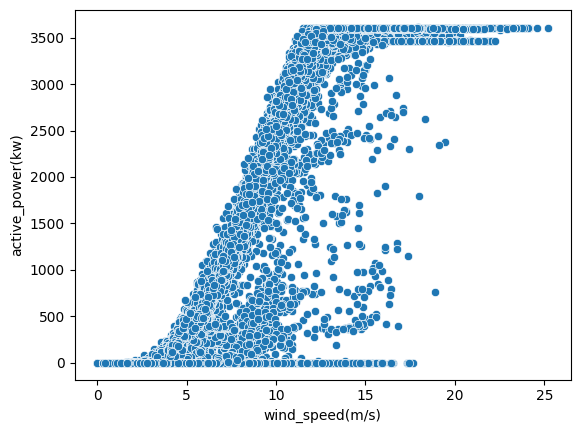

In [80]:
sns.scatterplot(data=turbina, x="wind_speed(m/s)", y="active_power(kw)")

Curva teórica esperada na proporção vento X energia gerada 

<Axes: xlabel='wind_speed(m/s)', ylabel='theoretical_curve(kwh)'>

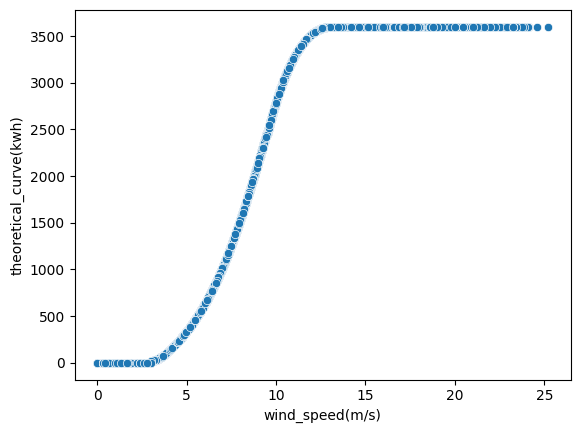

In [81]:
sns.scatterplot(data=turbina, x="wind_speed(m/s)", y="theoretical_curve(kwh)")

Nesta sessão irei estabelecer qual o limite mínimo e máximo, em seguida definir se a energia gerada está de acordo com o esperado

In [84]:
def get_inside_outside(data):
    min_limit = data["theoretical_curve(kwh)"] * 0.95
    max_limit = data["theoretical_curve(kwh)"] * 1.05
    power = data["active_power(kw)"]

    if power >= min_limit and power <= max_limit:
        result = 'Dentro' 
    elif power == 0:
        result = 'Zero'
    else:
        result = 'Fora'
    return result

In [89]:
turbina["Está no Limite?"] = turbina.apply(get_inside_outside, axis=1)
turbina

,date,active_power(kw),wind_speed(m/s),theoretical_curve(kwh),wind_direction,Está no Limite?
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,Oeste,Fora
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,Oeste,Fora
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,Oeste,Fora
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,Oeste,Fora
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,Oeste,Fora
...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,Leste,Fora
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,Leste,Fora
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,Leste,Fora
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,Leste,Dentro


Agora irei demonstrar via gráfico como está turbina está trabalhando, para avaliarmos se está de acordo com o esperado

<Axes: xlabel='wind_speed(m/s)', ylabel='active_power(kw)'>

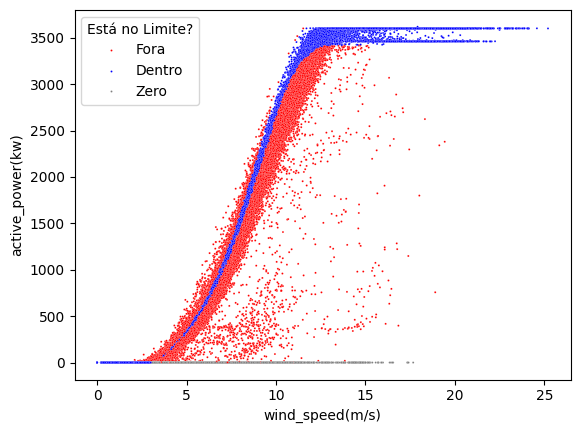

In [90]:
colors = {
    'Fora': 'red',
    'Zero': 'gray',
    'Dentro': 'blue'
}

sns.scatterplot(data=turbina, x="wind_speed(m/s)", y="active_power(kw)", hue="Está no Limite?", s=2, palette=colors)

##### Foi observado que existe uma forte dispersão em velocidades mais baixas do vento, porém em forças ade vento maiores, vemos que em determinado ponto existe uma grande quantidade de resultados aceitaveis.
- Vale pontuar que existem 2 linhas paralelas no máximo, algo passível de investigação por parte da equipe de engenheiro envolvidos

Vamos agora analise se existe alguma correlação entre a direção do vento e os resultados positivos e negativos

In [92]:
directions_colors = {
    'Norte': 'red',
    'Nordeste': 'blue',
    'Leste': 'orange',
    'Sudeste': 'gray',
    'Sul': 'black',
    'Sudoeste': 'yellow',
    'Oeste': 'pink',
    'Noroeste': 'purple',
}
turbina_inside = turbina[turbina["Está no Limite?"] == "Dentro"]
turbina_outside = turbina[turbina["Está no Limite?"] == "Fora"]

<Axes: xlabel='wind_speed(m/s)', ylabel='active_power(kw)'>

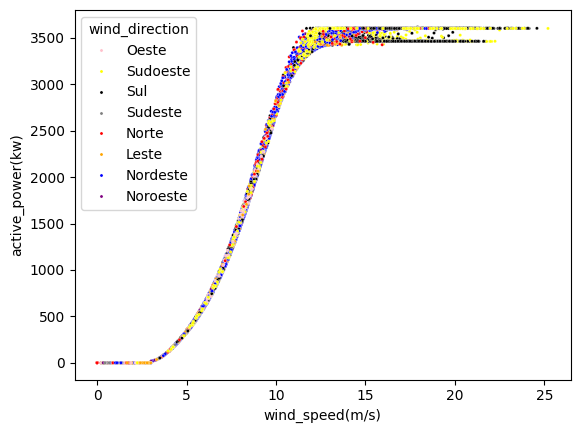

In [93]:
#Inicialmente irei analisar todos os resultados positivos
sns.scatterplot(data=turbina_inside, x="wind_speed(m/s)", y="active_power(kw)", hue="wind_direction", s=5, palette=directions_colors)

<Axes: xlabel='wind_speed(m/s)', ylabel='active_power(kw)'>

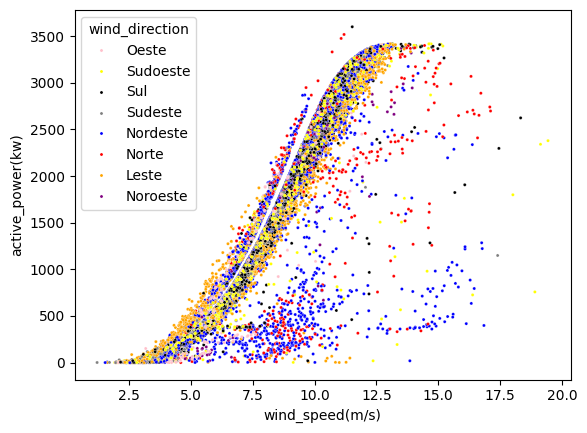

In [24]:
#Agora irei analisar todos os resultados negativos
sns.scatterplot(data=turbina_outside, x="wind_speed(m/s)", y="active_power(kw)", hue="wind_direction", s=5, palette=directions_colors)

##### Podemos perceber que existe algum tipo de dificuldade da turbina entregar tudo que se espera, ou mesmo chegar próximo ao que se espera quando esta apontada para o nordeste, enquanto que ao apontar para o Leste com o vento fraco, existe a tendência de haver uma maior entrega do que o esperado